# 5. From-scratch Model
* Going back to Tabular Data, Build a tabular model from scratch
* Utilize the Titanic Dataset

In [1]:
#Setting up libraries
import os
from pathlib import Path
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning Data

In [2]:
df = pd.read_csv('titanic_datasets/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
#Check null values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#Can replace null with mode for now. Store all the modes
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [5]:
#Fill the nulls with modes
df.fillna(modes, inplace=True)

In [6]:
#Quick summary of the numerical columns
import numpy as np
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

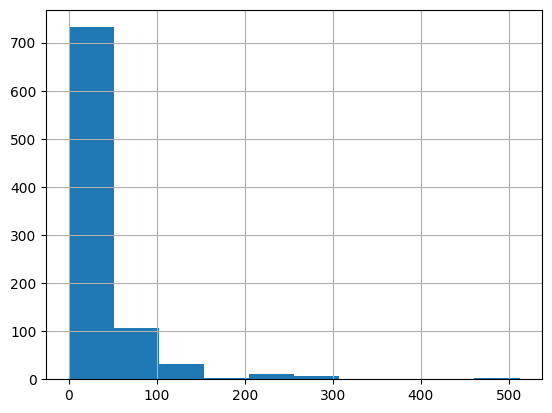

In [7]:
#Fare seems to have some outliers. Quick sketch of histogram:
df['Fare'].hist()

In [8]:
#Some linear models don't work with long tailed distributions
#Can take the log of this data
#Logs are used a lot in ML
#Since there are 0s in the fare column & log(0) is infinite - can do a simple trick of adding 1 to all values first
df['LogFare'] = np.log(df['Fare']+1)

<Axes: >

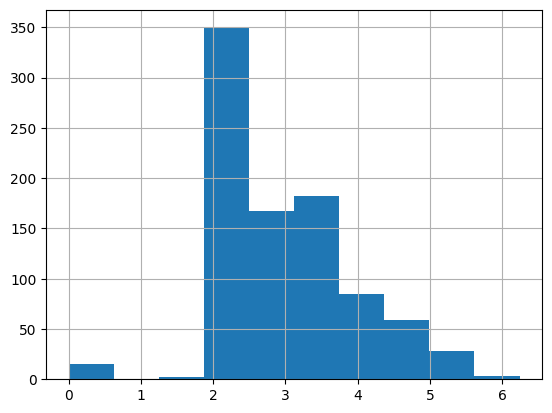

In [9]:
df['LogFare'].hist() 
#log is often used for money, population (things that can grow really fast, exponentially, etc.)

In [10]:
#pclass: not numeric, but categorical.
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [11]:
#Describe the non-numeric variables
df.describe(include=[object])
#can't multiply some of these values (S, B96 B98, male, etc.) by a coefficient

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [12]:
#This is where we need to create dummy variables
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns
#5 dummy cols are added to the end

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

## Now, need to create independent (predictors) and dependent (target) variables. 
* Both of them need to be PyTorch tensors
* Our dependent variable is 'Survived'

In [13]:
from torch import tensor
t_dep = tensor(df.Survived)
#survived is our dependent variable

In [14]:
#Independent vars are all continuous vars of interest + dummy variables
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float) #Note: PyTorch works with float numbers.
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [15]:
t_indep.shape
#We now have a matrix of indep vars and dep var, which can be used to calculate predictions/loss

torch.Size([891, 12])

### Setting up a Linear Model

In [16]:
torch.manual_seed(442) 

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5 #asks pytorch to give us 12 (n_coeff) random numbers between 0 and 1 and subtract a half.
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [17]:
#Each row will be calculated by the coefficients, adding them up. 
#No need to have a separate constant term (bias/intercept) or a column of all 1s.
#Since our dummy variables already cover the entire dataset (everyone's either a male or female), 
#we don't need a separate intercept term to cover rows that aren't part of a column
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [18]:
#Problem: sums of each row are dominated by first column (age) since it's bigger on avg than others. 
#Make all the columns contain #s from 0 to 1, dividing each column by its max
vals, indices = t_indep.max(dim=0) #dim=0 for maximum over the rows
t_indep = t_indep / vals

In [19]:
t_indep*coeffs #this problem has been solved

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

This is an example of broadcasting - acting as if there's a separate copy of the vector for every row of the matrix - divides each row of the matrix by the vector.

In [20]:
#Create predictions from our linear model
preds = (t_indep*coeffs).sum(axis=1) #add up over the columns = gives us predictions

In [21]:
#Take a look at the first few tensors
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

These predictions are meaningless since our coefficients are random - they're a starting point for the gradient descent process. To do a gradient descent, we need a loss function (Loss is a measure of how good or bad these coefficients are)
* One approach: taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent)

In [22]:
loss = torch.abs(preds-t_dep).mean() #remember t_dep: tensor(df.Survived)
loss

tensor(0.5382)

In [23]:
#Now, put this logic into functions to make it more convenient
def calc_preds(coeffs, indeps):
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### Gradient Descent

To get Pytorch to calculate gradients, we'll call requires_grad_() on our coeffs.
* For more info: https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work

In [24]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [25]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss #Loss stores our gradient function - 
#the function that Python remembers that it will have to undo those steps to go back to the gradient

tensor(0.5382, grad_fn=<MeanBackward0>)

In [26]:
loss.backward()

In [27]:
coeffs.grad # negative means increasing the age coeff, the loss would go down - so we should do that.

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [28]:
#Subtract the coeffs x the learning rate
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1) #0.1 learning rate worked pretty well
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


As you can see above, the loss went down from 0.5382 to 0.5197.

### Training the Linear Model

* Split dataset into training and validation dataset.

In [29]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)
#can use random split for this dataset.

In [30]:
#Indices of the rows that are going to be the validation set.
val_split

(#178) [303,778,531,385,134,476,691,443,386,128...]

In [31]:
#Apply these indices to the indep/dep variables
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

#### Create functions for the 3 things we did manually above: 
* updating coeffs
* doing one full grad descent step, and 
* initializing coeffs to random numbers

In [32]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [33]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [34]:
def init_coeffs(): 
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [35]:
#Now use these functions to train our model
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [36]:
#Our loss prints at the end of every step. Hopefully we'll see it go down, which it does.
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

In [37]:
#Take a look at the coeffs for each column
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

### Measuring Accuracy

Kaggle Competition is measured by ACCURACY (not loss). See how accurate we were on the validation set

In [38]:
#Calculate the predictions
preds = calc_preds(coeffs, val_indep)

In [39]:
#Assume passenger with a score of 0.5 is predicted to survive. 
#That means we're correct for each row where preds>0.5 is the same as the dependent variable
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [40]:
#This is our average accuracy
results.float().mean() #Not a bad start

tensor(0.7865)

In [41]:
#Create a function to calculate the accuracy for other models we train
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

### Using Sigmoid

In [42]:
#Some of our predictions of the probability of survival are >1 and some are <0
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

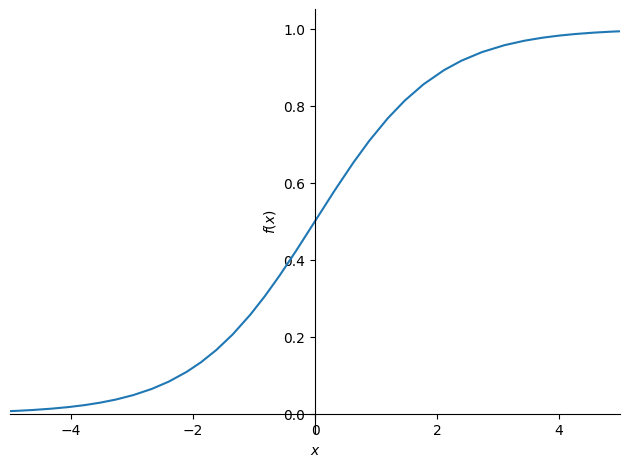

In [43]:
#We can use the sigmoid function to fix this
#Sigmoid has a minimum at zero and maximum at one, and is defined as follows:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [44]:
#PyTorch defines the sigmoid function, so we can modify calc_preds to use it
def calc_preds(coeffs, indeps): 
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [45]:
#Train a new model using the sigmoid function
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [46]:
#Both the loss and accuracy improved
acc(coeffs)

tensor(0.8258)

In [47]:
#Coefficients of the trained model
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

These coefficients seem reasonable since older people and males were less likely to survive, and first class passengers were more likely to survive.

### Using Matrix Product (skipped the submit results to Kaggle section)

In [48]:
#this is the inner most calculation to get the predictions
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1066,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [49]:
#Multiplying elem together and adding across rows == matrix-vector product
val_indep@coeffs
#Python uses the "@" operator to indicate matrix products (also supported by PyTorch tensors)
#This is much faster since matrix products in PyTorch are highly optimized

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

In [50]:
#Use this to replace how calc_preds work
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [51]:
#Here, we turn "coeffs" into a column vector (matrix with a single column) by passing a second argument '1' to torch.rand()
#indicating we want the coeffs to have one column
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [52]:
#Also turn the dep. variable into a column vector, by indexing the col. dim with the special value 'None'.
#This tells PyTorch to add a new dim in this position.
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [53]:
#Train the model as before and confirm we get identical outputs
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [54]:
#also the same accuracy as above.
acc(coeffs)

tensor(0.8258)

### Neural Network

In order to create a neural network, we need the following
* First, we need to create coeffs for each of our layers
* First set of coeffs will take our n_coeff inputs, and create n_hidden outputs
* We can choose whatever n_hidden we like (higher # gives our network more flexibility, but makes it slower and harder to train)
* Need a matrix of size n_coeff by n_hidden
* Divide these coeffs by n_hidden so that when we sum them up in the next layer, we end up with similar magnitude #s to what we started with
* Second layer will need to take the n_hidden inputs and create a single output -> we need a n_hidden by 1 matrix
* Second layer will also need a constant term added

In [55]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

With these coeffs, we can create the neural net. Key steps:
* Two matrix products indeps@l1 and res@l2 where res is the output of the first layer.
* First layer output is passed to F.relu (our non-linearity) 
* Second layer is passed to torch.sigmoid as before

In [56]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Now, add a loop to update each layer

In [57]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Ready to train the model

In [58]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [59]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [60]:
acc(coeffs) #Neural net is not any better than the linear model

tensor(0.8258)

### Deep Learning

Neural net uses one hidden layer so it doesn't count as "deep" learning.
But we can create additional coeffs for each layer, and add more matrix multiplications to make the neural net deep.

In [61]:
#This creates additional coeffs for each layer.
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [62]:
#Here, calc_preds is similar to before but now we loop through each layer, instead of listing them separately.
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [63]:
#Minor updates to the update_coeffs func since we've got layers and consts separated below
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [64]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [65]:
acc(coeffs) #Accuracy still the same. Not surprising since data set small.

tensor(0.8258)

Takeaway:
* The "real" deep learning models that are used in research and industry look very similar to this (basic steps are the same)

The biggest differences will be:
* How initialisation and normalisation is done to ensure the model trains correctly every time
* Regularization (to avoid over-fitting)
* Modifying the neural net itself to take advantage of knowledge of the problem domain
* Doing gradient descent steps on smaller batches, rather than the whole dataset.